In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

In [2]:
# Load dataset
train_df = pd.read_csv("../data/train/churn_train.csv")
test_df = pd.read_csv("../data/test/churn_test.csv")

In [3]:
# Display first few rows
train_df.head()

,Age,Avg Monthly GB Download,Avg Monthly Long Distance Charges,Churn Category,Churn Reason,Churn Score,City,CLTV,Contract,Country,...,Tenure in Months,Total Charges,Total Extra Data Charges,Total Long Distance Charges,Total Refunds,Total Revenue,Under 30,Unlimited Data,Zip Code,Churn
0,72,4,19.44,NaN,NaN,51,San Mateo,4849,Two Year,United States,...,25,2191.15,0,486.00,0.0,2677.15,0,1,94403,0
1,27,59,45.62,NaN,NaN,27,Sutter Creek,3715,Month-to-Month,United States,...,35,3418.20,0,1596.70,0.0,5014.90,1,1,95685,0
2,59,0,16.07,NaN,NaN,59,Santa Cruz,5092,Month-to-Month,United States,...,46,851.20,0,739.22,0.0,1590.42,0,0,95064,0
3,25,27,0.00,NaN,NaN,49,Brea,2068,One Year,United States,...,27,1246.40,30,0.00,0.0,1276.40,1,0,92823,0
4,31,21,17.22,Dissatisfaction,Network reliability,88,San Jose,4026,One Year,United States,...,58,3563.80,0,998.76,0.0,4562.56,0,1,95117,1


In [4]:
# Data Summary
print(train_df.info())
print(train_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4225 entries, 0 to 4224
Data columns (total 52 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                4225 non-null   int64  
 1   Avg Monthly GB Download            4225 non-null   int64  
 2   Avg Monthly Long Distance Charges  4225 non-null   float64
 3   Churn Category                     1121 non-null   object 
 4   Churn Reason                       1121 non-null   object 
 5   Churn Score                        4225 non-null   int64  
 6   City                               4225 non-null   object 
 7   CLTV                               4225 non-null   int64  
 8   Contract                           4225 non-null   object 
 9   Country                            4225 non-null   object 
 10  Customer ID                        4225 non-null   object 
 11  Customer Status                    4225 non-null   objec

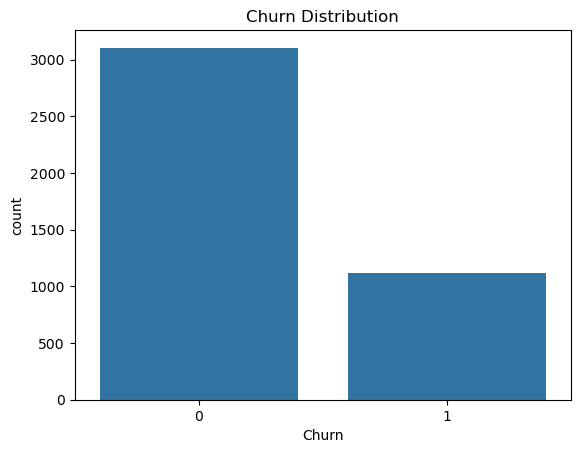

In [5]:
# Visualize target distribution
sns.countplot(x='Churn', data=train_df)
plt.title("Churn Distribution")
plt.show()

In [6]:
# Feature selection & preprocessing
X = train_df.drop(columns=['Churn'])
y = train_df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

In [10]:
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [11]:
# Train Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [12]:
# Evaluate Model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Test Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       611
           1       1.00      1.00      1.00       234

    accuracy                           1.00       845
   macro avg       1.00      1.00      1.00       845
weighted avg       1.00      1.00      1.00       845

Confusion Matrix:
 [[611   0]
 [  0 234]]


In [13]:
# Save Model
joblib.dump(model, "../models/churn_model.pkl")

['../models/churn_model.pkl']

In [14]:
# Conclusion
print("The model achieved a high accuracy and is ready for deployment.")

The model achieved a high accuracy and is ready for deployment.
